# Delayed Flights

**Autor**: Andrés Jahr

## Librerías

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

plt.rcParams["figure.figsize"] = (18,9)

## Importación de Datos

In [2]:
scl_df = pd.read_csv('dataset_SCL.csv', low_memory=False)

In [3]:
scl_df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


## Funciones Auxiliares

In [4]:
def variable_barplot(variable_name, dataframe):
    
    ''' Función que grafica un gráfico de barras utilizando un dataframe que contiene la frecuencia por opción
    de una variable. '''
    
    ax = sns.barplot(data=dataframe,
                x=variable_name,
                y='quantity')
    
    ax.set_title(f'Frecuencia de cada valor de la variable {variable_name}', fontsize=18)
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Cantidad")
    names = dataframe[variable_name]
    
    max_ = dataframe['quantity'].max()

    size = 'small'
        
    if len(names) > 10:
        
        ax.set_xticklabels(names, rotation = 90)
        
    if len(names) > 30:
        
        size = 'x-small'
        
        if len(names) >50:
            
            size = 'xx-small'

    for index, row in dataframe.iterrows():
        
        ax.text(row.name, row.quantity + max_*0.005, format(int(row.quantity), ",").replace(',',"."),
                ha="center", rotation='horizontal',
       va='baseline', size=size, color='black', weight='normal')
        
    plt.show()

In [5]:
def variable_qty(variable_name, dataframe, sort_val=False):
    
    ''' Función que genera un dataframe que contiene la frecuencia (en cantidad y porcentage) de cada valor
     de una variable '''
    
    new_df = pd.DataFrame(dataframe.groupby(variable_name).size())
    new_df.columns = ['quantity']
    new_df['percentage'] = round(new_df['quantity']*100/len(dataframe), 2)

    if sort_val:
        
        new_df = new_df.sort_values(by='quantity',ascending=False)
        
    return new_df
    

In [6]:
def high_season(month, day):
    
    ''' Función que retorna 1 o 0 dependiendo si el mes y el día pertencen a temporada alta'''
        
    fixed_date = (month, day)
    
    if (12, 15) <= fixed_date <= (12, 31) or (1, 1) <= fixed_date <= (3, 31) or (7, 15) <= fixed_date <= (7, 31) or (9, 11) <= fixed_date <= (9, 30):
    
        return 1
    
    else:
        
        return 0 

In [7]:
def day_period(date):
    
    ''' Función que retorna mañana, tarde o noche dependiendo el periodo indicado en la fecha '''
    
    time = date.time()
    time = (time.hour, time.minute)
    
    if (5, 0) <= time <= (11, 59):
        
        return 'mañana'
    
    elif (12, 0) <= time <= (18, 59):
        
        return 'tarde'
    
    elif (19, 0) <= time <= (23, 59) or (0, 0) <= time <= (4, 59):
        
        return 'noche'

In [8]:
def write_csv(dataframe):
    
    ''' Función que genera un archivo csv con los nuevos atributos: temporada_alta, dif_min, 
    atraso_15 y periodo_dia'''
    
    with open('synthetic_features.csv', mode='w') as csv_file:
        
        csv_file = csv.writer(csv_file, delimiter=',',quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        csv_file.writerow(["temporada_alta", "dif_min", "atraso_15", "periodo_dia"])
        
        for i in dataframe.index:
            
            csv_file.writerow([dataframe['temporada_alta'][i], dataframe['dif_min'][i],
                              dataframe['atraso_15'][i], dataframe['periodo_dia'][i]])


In [9]:
def plot_cm(y_true, y_pred, figsize=(8,8)):
    
    ''' Función que tiene como finalidad mostrar la matriz de confusión como un mapa de calor'''
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        
        for j in range(ncols):
            
            c = cm[i, j]
            p = cm_perc[i, j]
            
            if i == j:
                
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                
            elif c == 0:
                
                annot[i, j] = '0.0%'
                
            else:
                
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Valores Verdaderos'
    cm.columns.name = 'Predicción'
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [10]:
def random_forest_model(estimators=100, show=False):
    
    ''' Función que realiza el modelo de random forest e imprime su precisión y su matriz de confusión'''
    
    random_forest = RandomForestClassifier(n_estimators=estimators, random_state=42)
    random_forest.fit(X_train, y_train.values.ravel())
    target_pred = random_forest.predict(X_test)
    acc = round(accuracy_score(y_test, target_pred) * 100,2)
    accuracy_cross_val = cross_val_score(random_forest, X_train, y_train.values.ravel(), scoring='accuracy', cv = 10)
    accuracy_mean = round(accuracy_cross_val.mean() * 100,2)
    print(f"El accuracy obtenido en cross validation es de {accuracy_mean}%")
    print()
    print(f'El accuracy del set de test es de {acc}%')

    if show:
        
            plot_cm(y_test, target_pred)
            
    return random_forest

In [11]:
def predict_probability(model, day, month, daynom, flight_type, company, destiny, period):
    
    ''' Función que entrega la probabilidad de atraso de un vuelo '''
    
    prediction = model.predict_proba([[day, month, daynom, flight_type, company, destiny, period]])
        
    delay = round(prediction[0][1] * 100, 2)
    
    print(f'La probabilidad de que este vuelo se atrase es de {delay}%')

In [12]:
def knn_model(neighbors, weights='uniform', p=2, show=False):
    
    ''' Función que genera un modelo knn, imprimiendo su precisión y un mapa de calor representando 
    la matriz de confusión '''
    
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, p=p)
    knn.fit(X_train, y_train.values.ravel())
    target_pred = knn.predict(X_test)
    acc = round(accuracy_score(y_test, target_pred) * 100,2)
    accuracy_cross_val = cross_val_score(knn, X_train, y_train.values.ravel(), scoring='accuracy', cv = 10)
    accuracy_mean = round(accuracy_cross_val.mean() * 100,2)
    print(f"El accuracy obtenido en cross validation es de {accuracy_mean}%")
    print()
    print(f'El accuracy del set de test es de {acc}%')
    
    if show:
        
            plot_cm(y_test, target_pred)


In [13]:
def svc_model(show=False):
    
    ''' Función que genera un modelo svc, imprimiendo su precisión y un mapa de calor representando 
    la matriz de confusión '''
    
    
    svc = SVC(random_state=42)
    svc.fit(X_train, y_train.values.ravel())
    target_pred = svc.predict(X_test)
    acc = round(accuracy_score(y_test, target_pred) * 100,2)
    accuracy_cross_val = cross_val_score(svc, X_train, y_train.values.ravel(), scoring='accuracy', cv = 10)
    accuracy_mean = round(accuracy_cross_val.mean() * 100,2)
    print(f"El accuracy obtenido en cross validation es de {accuracy_mean}%")
    print()
    print(f'El accuracy del set de test es de {acc}%')
    

    if show:
        
            plot_cm(y_test, target_pred)

## Exploración de datos

#### Tipos de datos

In [14]:
scl_df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

Se puede ver que todos los atributos a excepción de DIA, MES y AÑO son del tipo string o combinados. Para análisis posteriores se trsnsformarán las columnas Fecha-I y Fecha-O a datetime:

In [15]:
scl_df['Fecha-I'] = pd.to_datetime(scl_df['Fecha-I'])
scl_df['Fecha-O'] = pd.to_datetime(scl_df['Fecha-O'])

#### Datos nulos

Primero se verifica si es que existen datos nulos en la base de datos:

In [16]:
scl_df.isnull().values.any()

True

Como existen datos nulos, se verifica a qué columna pertenecen:

In [17]:
for i in scl_df.columns: 
    print(i + ': ' + str(scl_df[i].isnull().sum()))

Fecha-I: 0
Vlo-I: 0
Ori-I: 0
Des-I: 0
Emp-I: 0
Fecha-O: 0
Vlo-O: 1
Ori-O: 0
Des-O: 0
Emp-O: 0
DIA: 0
MES: 0
AÑO: 0
DIANOM: 0
TIPOVUELO: 0
OPERA: 0
SIGLAORI: 0
SIGLADES: 0


Existe solo 1 dato nan en todo el archivo que pertenece a la columna Vlo-O. Dado que el número de vuelo no debiese variar respecto al programado, se rellenará esa celda con el valor de Vlo-I:

In [18]:
for i in scl_df.index:
    if pd.isna(scl_df['Vlo-O'][i]):
        scl_df.loc[i, 'Vlo-O'] = scl_df['Vlo-I'][i]


Se vuelve a verificar que no hayan nulos:

In [19]:
scl_df.isnull().values.any()

False

### Distribución de los Datos

#### Fecha-I y Fecha-O 

Como las fechas son prácticamente únicas, no se va a analizar su distribución ya que no aportarían nada al modelo (ya está separado el día, mes, año y día de la semana).

#### Vlo-I y Vlo-O

Se puede analizar la cantidad de valores únicos en Vlo-I y Vlo-O:

In [20]:
print(f'Cantidad de valores únicos de Vlo-I: {scl_df["Vlo-I"].nunique()}')
print(f'Cantidad de valores únicos de Vlo-O: {scl_df["Vlo-O"].nunique()}')

Cantidad de valores únicos de Vlo-I: 584
Cantidad de valores únicos de Vlo-O: 861


Hay dos aspectos que destacar en estos valores. El primero es que esto indica que hay una variación en los números de vuelos programados y de los que operan. Lo segundo es que hay una cantidad grande de valores únicos en los vuelos. Por lo tanto, estas columnas se descartarán del análisis. Los atributos OPERA, SIGLAORI y SIGLADES presentan la misma información.

#### Ori-I, Ori-O y SIGLAORI

Los siguientes dataframes indican que el 100% de los lugares de origen son SCEL, es decir, santiago. Por lo tanto, los atributos Ori-I, Ori-O y SIGLAORI serán descartados del modelo ya que no generan un aporte a la predicción. 

In [21]:
ori_i_qty = variable_qty('Ori-I',scl_df)
ori_i_qty

,quantity,percentage
Ori-I,,
SCEL,68206,100.0


In [22]:
ori_o_qty = variable_qty('Ori-O',scl_df)
ori_o_qty

,quantity,percentage
Ori-O,,
SCEL,68206,100.0


In [23]:
siglaori_qty = variable_qty('SIGLAORI',scl_df)
siglaori_qty

,quantity,percentage
SIGLAORI,,
Santiago,68206,100.0


#### Emp-I, Emp-O y OPERA

A continuación se muestran los valores únicos por variable:

In [24]:
print(f'Cantidad de valores únicos de Emp-I: {scl_df["Emp-I"].nunique()}')
print(f'Cantidad de valores únicos de Emp-O: {scl_df["Emp-O"].nunique()}')
print(f'Cantidad de valores únicos de OPERA: {scl_df["OPERA"].nunique()}')

Cantidad de valores únicos de Emp-I: 30
Cantidad de valores únicos de Emp-O: 32
Cantidad de valores únicos de OPERA: 23


Esto indica una diferencia entre la cantidad de operadores de vuelo entre las columnas. Las tres variables debiesen presentar los mismos resultados. Dado lo anterior, se tomará como supuesto que es la columna OPERA la más precisa (asumiendo que podrían haber dos códigos que hablen de la misma operadora).

Se puede ver entonces la distribución de los valores en el atributo OPERA:

In [25]:
operates_qty = variable_qty('OPERA',scl_df, True)
operates_qty

,quantity,percentage
OPERA,,
Grupo LATAM,40892,59.95
Sky Airline,14298,20.96
Aerolineas Argentinas,1949,2.86
Copa Air,1850,2.71
Latin American Wings,1674,2.45
Avianca,1152,1.69
JetSmart SPA,1095,1.61
Gol Trans,806,1.18
American Airlines,757,1.11


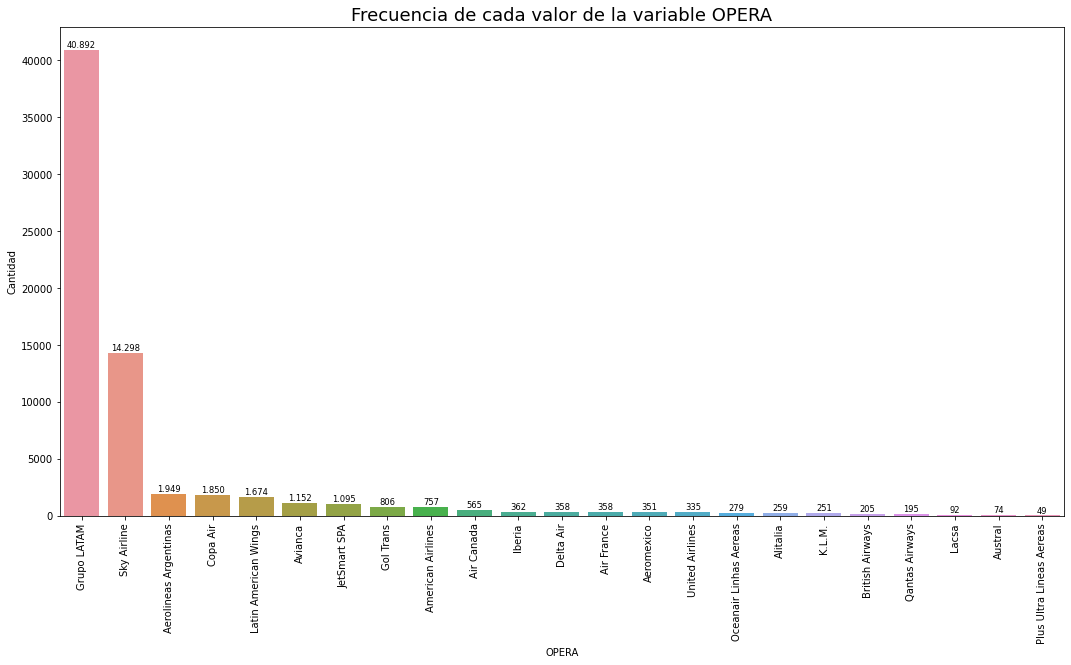

In [26]:
operates_qty = operates_qty.reset_index(drop=False)

variable_barplot('OPERA', operates_qty)

Lo destacable de esto es que casi un 60% de los datos provienen de LATAM y un 20% de Sky Airlines. Si es que este es un análisis exlusivo para LATAM esto no es un gran problema. Incluso se podría hacer un análisis exclusivo filtrando todos los valores por el operador LATAM. En otro caso, si este análisis se quisiera utilizar a modo general en las aerolineas los datos estarían sesgados, ya que el comportamiento estaría determinado en un 805 por dos aerolineas que pueden tener un funcionamiento totalmente distinto al resto.

#### DIA

En el día se muestra una distribución equitativa. A excepción del día 31 ya que no está presente en todos los meses. También se puede ver una pequeña disminución en el día 30 y 29 debido a que febrero no los contiene.

In [27]:
day_qty = variable_qty('DIA',scl_df)
day_qty

,quantity,percentage
DIA,,
1,2208,3.24
2,2223,3.26
3,2271,3.33
4,2215,3.25
5,2241,3.29
6,2275,3.34
7,2264,3.32
8,2213,3.24
9,2227,3.27


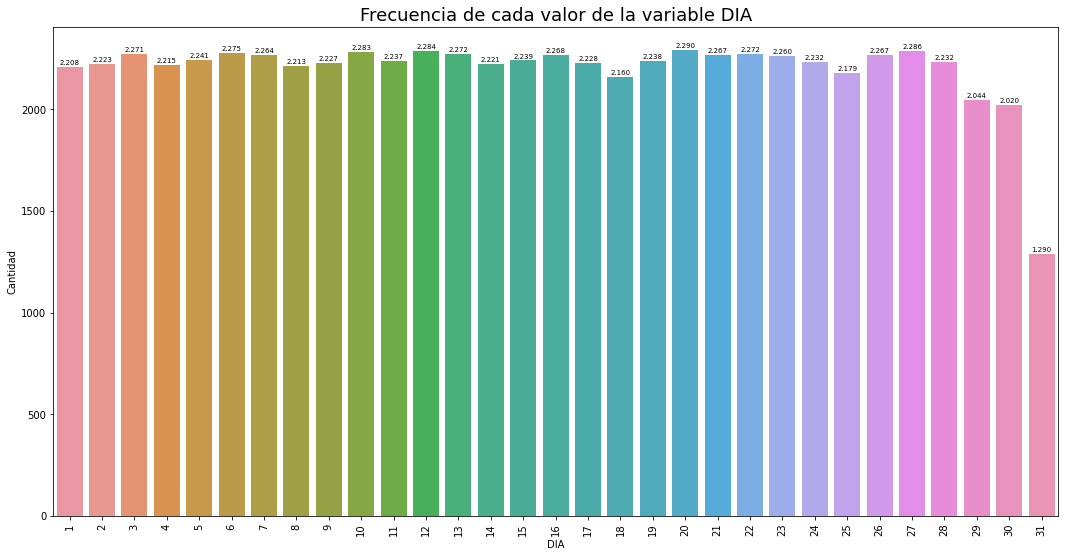

In [28]:
day_qty = day_qty.reset_index(drop=False)

variable_barplot('DIA', day_qty)

#### MES

En los meses los valores también son distribuidos equitativamente. Se presenta una leve baja en los meses de abri-mayo-junio y una leve alza en los meses de julio-octubre-noviembre-diciembre-enero. Lo anterior se puede deber a un alza de vuelos en estas fecha por periodos de vacaciones.

In [29]:
month_qty = variable_qty('MES',scl_df)
month_qty

,quantity,percentage
MES,,
1,6108,8.96
2,5561,8.15
3,5482,8.04
4,5020,7.36
5,5240,7.68
6,4981,7.30
7,5992,8.79
8,5744,8.42
9,5610,8.23


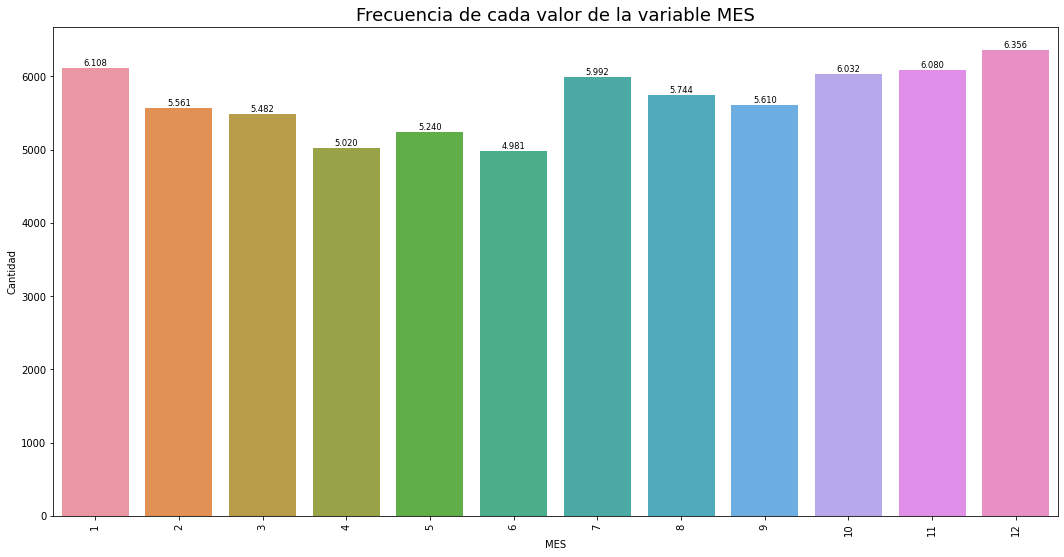

In [30]:
month_qty = month_qty.reset_index(drop=False)

variable_barplot('MES', month_qty)

#### AÑO

En términos predictivos es entendible que esta variable no aporte al modelo debido a que las estimaciones nuevas serán sobre nuevos años, valores que no estarán en el set de entrenamientos.

De todas formas, su distribución se ve de la siguiente manera:

In [31]:
year_qty = variable_qty('AÑO', scl_df, True)
year_qty

,quantity,percentage
AÑO,,
2017,68204,100.0
2018,2,0.0


Ya que aproximadamente los valores provienen en un 100% del 2017 se descarta definitivamente el atributo del modelo.

#### DIANOM

Para los días de semana, existe también una distribución bastante equitativa. El único día con un porcentaje notoriamente más bajo es el día sábado, pero no es suficientemente significavo como para tener un sesgo en los datos.

In [32]:
daynom_qty = variable_qty('DIANOM', scl_df)
new_order = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
daynom_qty = daynom_qty.reindex(new_order)
daynom_qty

,quantity,percentage
DIANOM,,
Lunes,10131,14.85
Martes,9662,14.17
Miercoles,9722,14.25
Jueves,10251,15.03
Viernes,10292,15.09
Sabado,8352,12.25
Domingo,9796,14.36


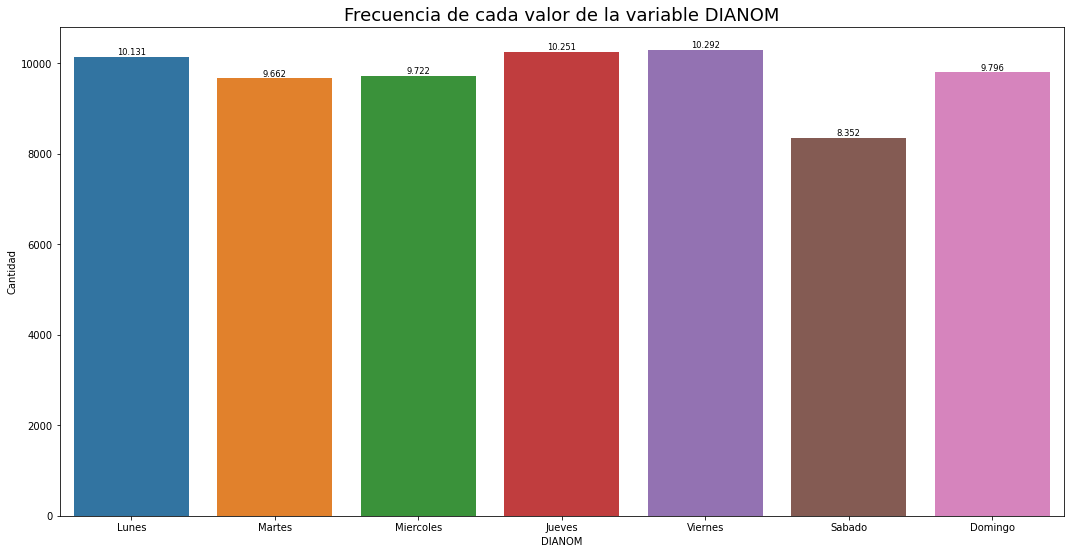

In [33]:
daynom_qty = daynom_qty.reset_index(drop=False)

variable_barplot('DIANOM', daynom_qty)

#### TIPOVUELO

Esta variable presenta que existe una cantidad similar de datos que provienen de vuelos nacionales como internacionales:

In [34]:
type_qty = variable_qty('TIPOVUELO', scl_df, True)
type_qty

,quantity,percentage
TIPOVUELO,,
N,36966,54.2
I,31240,45.8


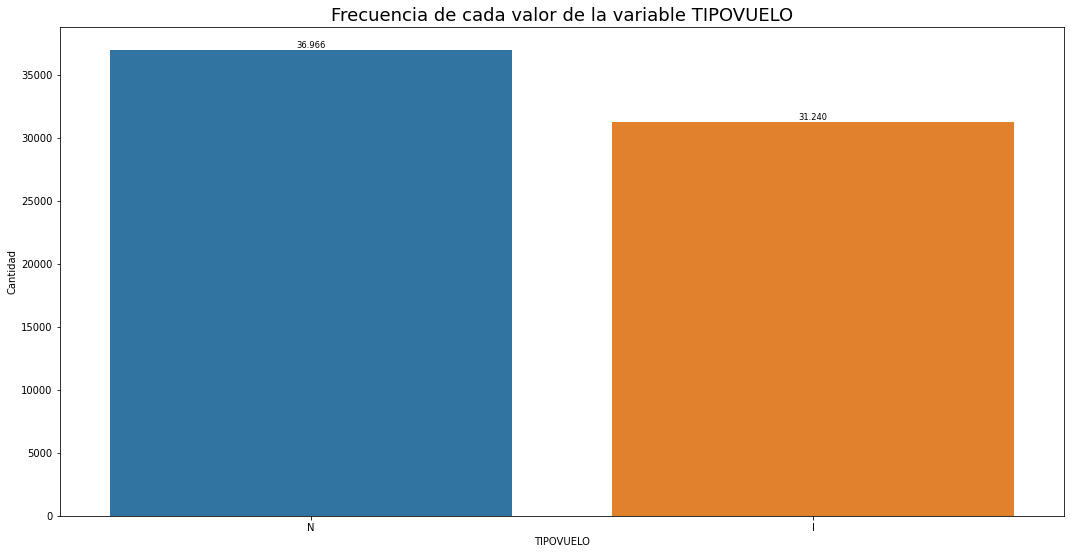

In [35]:
type_qty = type_qty.reset_index(drop=False)

variable_barplot('TIPOVUELO', type_qty)

#### SIGLADES

Por último, se presentan grandes diferencias en la cantidad de datos que hay respecto a cada destino. Un 9.3% proviene de Buenos Aires, por ejemplo, lo que equivale a 6335 datos, mientras que hay otros como Washington que tiene solo 1 caso en toda la base de datos. Estas diferencias se pueden deber a que los datos provienen principalmente de LATAM y Sky Airlines, aerolineas que posiblemente predominan en vuelos sumericanos y nacionales. Esto puede presentar un problema en las predicciones fuera de esta zona, dado que la cantidad de casos puede ser tan bajo en algunos casos que no permita entrenarse el modelo lo suficientemente bien para generalizar el comporamiento de todos los vuelos.

In [36]:
destiny_qty = variable_qty('SIGLADES', scl_df, True)
destiny_qty

,quantity,percentage
SIGLADES,,
Buenos Aires,6335,9.29
Antofagasta,5786,8.48
Lima,5270,7.73
Calama,5146,7.54
Puerto Montt,4357,6.39
...,...,...
Cataratas Iguacu,2,0.00
"Pisco, Peru",1,0.00
Puerto Stanley,1,0.00


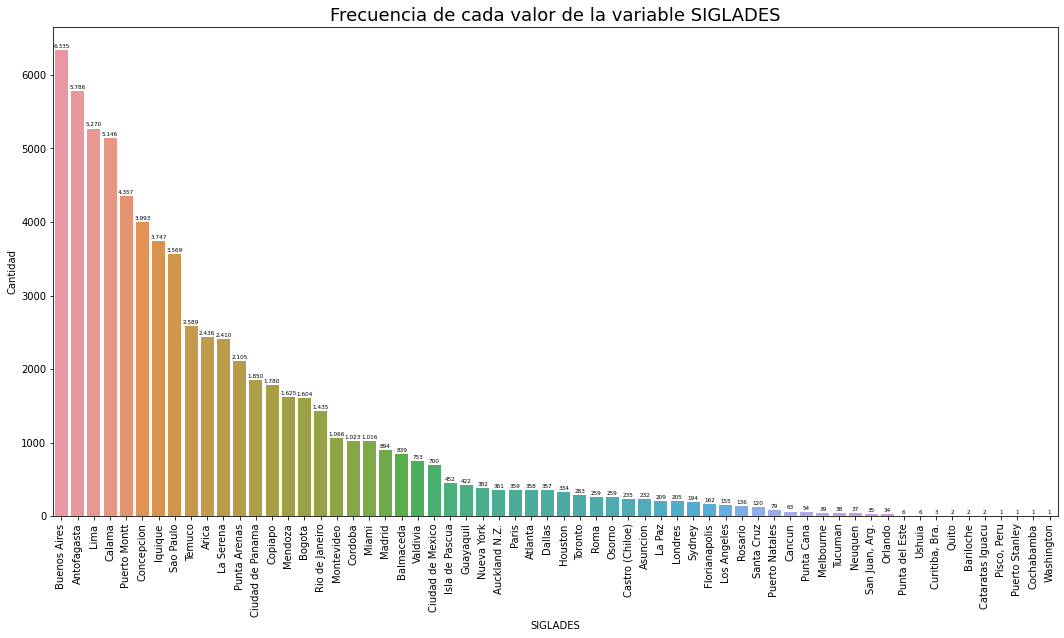

In [37]:
destiny_qty = destiny_qty.reset_index(drop=False)

variable_barplot('SIGLADES', destiny_qty)

## Columnas Adicionales

A continuación se generan los atributos adicionales del análisis y se presentan los dataframes con sus distribuciones:

#### temporada_alta

In [38]:
scl_df['temporada_alta'] = scl_df.apply(lambda x: high_season(x.MES, x.DIA), axis=1)

Existen más vuelos de temporada "no alta" que alta en la base de datos:

In [39]:
high_season_qty = variable_qty('temporada_alta', scl_df, True)
high_season_qty

,quantity,percentage
temporada_alta,,
0,40538,59.43
1,27668,40.57


#### dif_min

In [40]:
scl_df['dif_min'] = (scl_df['Fecha-O'] - scl_df['Fecha-I'])

In [41]:
scl_df['dif_min'] = scl_df['dif_min'].apply(lambda x: x.total_seconds() / 60)

En este dataframe se presenta que un 7% de los vuelos salieron al tiempo programado. Se muestra un resumen debido a la cantidad de opciones posibles de diferencia de minutos:

In [42]:
dif_qty = variable_qty('dif_min', scl_df, True)
dif_qty.head()

,quantity,percentage
dif_min,,
0.0,4789,7.02
-1.0,4026,5.90
1.0,3921,5.75
2.0,3622,5.31
-2.0,3582,5.25


#### atraso_15

In [43]:
scl_df['atraso_15'] = scl_df['dif_min'].apply(lambda x: 1 if x > 15 else 0)

Un 81% de los datos utilizados pertenecen a casos de no atraso, mientras que solo un 18.5% a casos de atraso. Eso muestra una distribución dispar entre las clases. Idealmente habría sido el caso de tener igual cantidad de datos en ambos casos.

In [44]:
delay_qty = variable_qty('atraso_15', scl_df, True)
delay_qty

,quantity,percentage
atraso_15,,
0,55592,81.51
1,12614,18.49


#### periodo_dia

In [45]:
scl_df['periodo_dia'] = scl_df['Fecha-I'].apply(day_period)

En el periodo del día, se tiene una cantidad similar entre las opciones, a diferencia de la noche en donde se tiene un 12% menos de datos. 

In [46]:
period_qty = variable_qty('periodo_dia', scl_df, True)
period_qty

,quantity,percentage
periodo_dia,,
tarde,25506,37.40
mañana,25352,37.17
noche,17348,25.43


Finalmente el dataframe queda de la siguiente forma:

In [47]:
scl_df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,noche


#### Generación de csv 

Ejecutando la siguiente linea se genera el csv con las columnas temporada_alta, df_min, atraso_15 y periodo_dia:

In [48]:
write_csv(scl_df)

## Tasa de Atraso

#### Atraso por Destino

La tasa de atraso por destino tiene grandes diferencias dependiendo del lugar a donde se dirija el vuelo. Esto si tiene como riesgo el sesgo que contraen ciertos destinos. Por ejemplo, Quito tiene solo 2 datos y ambos fueron vuelos atrados, por ende, la tasa dice que el 100% de los vuelos a Quito tienen atraso. Lo mismo sucede con Washington, hay solo un vuelo a ese destino en la base de datos y en este no hubo atraso, por lo tanto se le está diciendo al modelo que el 0% de estos vuelos se atrasarán. Si bien este atributo puede ser buen predictor también tiene el riesgo de generar sesgos en el set de entrenamiento.

In [49]:
delay_per_destination = pd.DataFrame(scl_df.groupby(['SIGLADES'])['atraso_15'].mean())
delay_per_destination = delay_per_destination.sort_values(by='atraso_15', ascending=False)

In [50]:
delay_per_destination

,atraso_15
SIGLADES,
Quito,1.000000
Puerto Stanley,1.000000
Cochabamba,1.000000
Ushuia,0.666667
Sydney,0.582474
...,...
Houston,0.050898
"Curitiba, Bra.",0.000000
Cataratas Iguacu,0.000000


#### Atraso por Aerolínea

En las operadoras de aerolineas se presentan grandes diferencias en su tasa de atrasos. Por ejemplo, Plus Ultra Lineas Aereas muestra que el 61% de sus casos son de atrasos, mientras que Grupo Latam un 17%. Esta variable puede ser buena predictora debido a las diferencias que muestran cada una de las compañías.

In [51]:
delay_per_company = pd.DataFrame(scl_df.groupby(['OPERA'])['atraso_15'].mean())
delay_per_company = delay_per_company.sort_values(by='atraso_15', ascending=False)

In [52]:
delay_per_company

,atraso_15
OPERA,
Plus Ultra Lineas Aereas,0.612245
Qantas Airways,0.579487
Air Canada,0.456637
Latin American Wings,0.406810
Gol Trans,0.356079
Avianca,0.265625
Aerolineas Argentinas,0.240123
Austral,0.202703
JetSmart SPA,0.178995


#### Atraso por Mes del Año

Los meses muestran diferencias significativas en sus tasas de atraso. Meses como abril tienen solo un 11% de vuelos atrasados, mientras que julio, octubre y diciembre superan el 20%. Esto se puede deber a que son meses de vacaciones o festivos por lo que pueden tener más frecuencia y gente en aeropuertos. Dado lo anterior esta variable debiese ser buena predictora.

In [53]:
delay_per_month = pd.DataFrame(scl_df.groupby(['MES'])['atraso_15'].mean())

In [54]:
delay_per_month

,atraso_15
MES,
1,0.160118
2,0.151591
3,0.115104
4,0.116534
5,0.157824
6,0.171050
7,0.293391
8,0.173398
9,0.172371


#### Atraso por Día de la Semana

Los días lunes y viernes muestran una tasa de atrasos sobre el 20%. Otros días de la semana se encuentran entre 16% y 19%. Si bien las diferencias no son tan grandes, si muestra una tendencia a que hay atrasos al comenzar la semana y el fin de semana. Por lo tanto, esta variable puede ser buena predictora.

In [55]:
delay_per_day = pd.DataFrame(scl_df.groupby(['DIANOM'])['atraso_15'].mean())
delay_per_day = delay_per_day.reindex(new_order)

In [56]:
delay_per_day

,atraso_15
DIANOM,
Lunes,0.202152
Martes,0.169116
Miercoles,0.170850
Jueves,0.199493
Viernes,0.222017
Sabado,0.163194
Domingo,0.161086


#### Atraso por Temporada

El atraso por temporada presenta valores similares en su tasa, es decir, sea temporada alta o baja no existe una tendencia que muestre que hayan más vuelos atrasado que puntuales en tales fechas. Por lo tanto es probable que esta variable no sea la mejor predictora de los vuelos atrasados.

In [57]:
delay_per_season = pd.DataFrame(scl_df.groupby(['temporada_alta'])['atraso_15'].mean())

In [58]:
delay_per_season

,atraso_15
temporada_alta,
0,0.187404
1,0.181329


#### Atraso por Tipo de Vuelo

Las diferencias entre vuelos nacionales e internacionales son de un 7%. Esta variable muestra que hay más atrasos en los vuelos internacionales por lo que puede aportar a la predicción.

In [59]:
delay_per_type = pd.DataFrame(scl_df.groupby(['TIPOVUELO'])['atraso_15'].mean())

In [60]:
delay_per_type

,atraso_15
TIPOVUELO,
I,0.225608
N,0.150571


#### Atraso por Periodo del Día

Entre los periodos del día no hay mucha diferencia. La mañana es el único momento que muestra menor proporción de atrasos, sugiriendo que su impacto puede ser menor en el modelo:

In [61]:
delay_per_period = pd.DataFrame(scl_df.groupby(['periodo_dia'])['atraso_15'].mean())

In [62]:
delay_per_period

,atraso_15
periodo_dia,
mañana,0.160066
noche,0.200023
tarde,0.199404


#### Atraso por Día

El día tiene variaciones en su tasa de atrasos. Por ejemplo en la quincena (día 15) se presenta la tasa más alta, evidenciando que en días mas recurridos podría existir mayor cantidad de atrasos.

In [63]:
delay_per_numday = pd.DataFrame(scl_df.groupby(['DIA'])['atraso_15'].mean())

In [64]:
delay_per_numday

,atraso_15
DIA,
1,0.148551
2,0.158345
3,0.176134
4,0.189616
5,0.174476
6,0.197363
7,0.158127
8,0.162223
9,0.178267


## Modelo

Para medir la performance de los modelos se utilizará una matriz de confusión. Además se entregarán los valores de su accuracy (como medidor principal de rendimiento) y de su precisión y recall (para obtener una proporción de falsos positivos y negativos). También se considerará el accuracy entregado por un cross validation de 10 folds.

#### Selección de variales

Dado el análisis anterior, las variables independientes que se considerarán para el modelo serán DIA, MES, DIANOM, TIPOVUELO, OPERA, SIGLADES y periodo_dia. La variable target dependiente será atraso_15 la cual puede tomar valor 0 o 1 dependiendo si hubo un atraso mayor a 15 minutos en el vuelo.

La variable dif_min no se considerará porque representa lo mismo que atraso_15. Además no se puede obtener tal información sin que el vuelo ya haya despegado. 

Las variables de fecha no se considerarán porque entregan la misma información que DIA y AÑO. 

Las variables Vlo-I y Vlo-O no se considerarán por entregar la misma información que SIGLAORI, SIGLADES y OPERA.

Las variables Ori-I, Ori-O y SIGLAORI no se considerarán por ser todos los vuelos de origen Santiago.

Las variables Emp-I y Emp-O no se considerarán por entregar la misma información que OPERA.

Las variables Des-I y Des-O no se considerarán por entregar la misma información que SIGLADES.

La variable AÑO no se considerará por ser casi 100% de los datos del 2017.

La variable temporada_alta no se considerará por tener una tasa muy similar entre atrasos en temporada alta y "no alta".

#### Set de entrenmiento y target

Luego se hace la subselección de columnas del dataframe anterior y de la columna target:

In [65]:
training_df = scl_df[['DIA', 'MES', 'DIANOM', 'TIPOVUELO','OPERA', 'SIGLADES', 'periodo_dia']]

target = scl_df[['atraso_15']]

In [66]:
training_df.head()

,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,periodo_dia
0,1,1,Domingo,I,American Airlines,Miami,noche
1,2,1,Lunes,I,American Airlines,Miami,noche
2,3,1,Martes,I,American Airlines,Miami,noche
3,4,1,Miercoles,I,American Airlines,Miami,noche
4,5,1,Jueves,I,American Airlines,Miami,noche


In [67]:
target.head()

,atraso_15
0,0
1,0
2,0
3,0
4,0


#### Encoding

Dado que DIA, MES, DIANOM y periodo_dia son ordinales se aplicará LabelEncoding para transformar las variables catergóricas a numéricas, de tal forma que puedan ser utilizadas en los modelos.

In [68]:
d = defaultdict(LabelEncoder)
training_df = training_df.apply(lambda x: d[x.name].fit_transform(x))

In [69]:
training_df

,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,periodo_dia
0,0,0,0,0,5,34,1
1,1,0,2,0,5,34,1
2,2,0,3,0,5,34,1
3,3,0,4,0,5,34,1
4,4,0,1,0,5,34,1
...,...,...,...,...,...,...,...
68201,21,11,6,0,14,28,2
68202,24,11,2,0,14,28,2
68203,26,11,4,0,14,28,2
68204,28,11,6,0,14,28,2


#### Separación de datos

Los datos se separarán en un set de entrenamiento y de testeo en una proporción de 80% y 20% respectivamente. De esta forma se podrá evaluar el rendimiento del modelo.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(training_df, target, test_size=0.2, random_state=42)

#### Random Forest

Un random forest es un modelo que provienen de un conjunto de árboles de decisión. La fortaleza que tiene este algoritmo es que combina árboles de manera random, es decir, no se enfoca solo en encontrar el feature que separe un nodo de la mejor manera, sino que le da diversidad al probar con muchos estimadores, entregando un resultado más robusto (menos varianza) y con un mejor rendimiento (generalmente).

A continuación se hace la prueba de este modelo:

El accuracy obtenido en cross validation es de 79.2%

El accuracy del set de test es de 79.12%


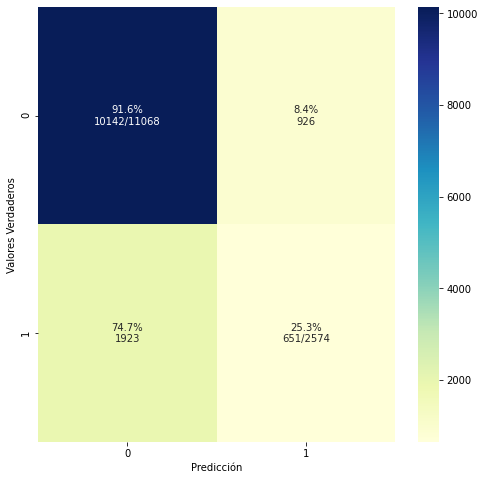

In [71]:
random_forest = random_forest_model(show=True)

Los resultados indican un 79.12% de accuracy, es decir, en casi un 80% de los casos del set de testeo se predijo de manera correcta la clase.

De todas formas, la matriz de confusión muestra que la clasificación con mejor rendimiento proviene cuando no hay atraso (con un 91.6%) , mientras que cuando si hay atraso, solo en un 25.3% de los casos se predijo correctamente.

Esto indica un problema con el label 1 (atraso), ya que en más de la mitad (casi 75%) de los casos hubo predicción de que el vuelo no iba a tener atraso, demostrando que el modelo no se está ajustando de la mejor forma a los casos de atraso.

Además, en este modelo la precisión de atraso es de 41.28%, es decir, en un 41% de los casos en que se predijo que hubo atraso, efectivamente era un atraso. El recall, como se mencionó anteriormente, sería de 25.3%, esto significa que en un 25% de los casos en que realmente hubo atraso se predijo correctamente que era atraso.

A pesar de estos valores el accuracy total no es bajo (casi 80%). Esto se debe a que la mayoría de los datos en el set total y set de testeo proviene de situaciones en que no hubo atraso, por lo que el generar un error al predecir que si hubo atraso no afecta tanto en los datos totales de rendimiento.

Lo ideal en cualquier caso sería tener un rendimiento más alto para que el modelo sea más confiable.

Por otro lado, se puede ver que los features con mayor importancia para el modelo fueron el DIA, influyendo un 32% y SIGLADES, influyendo un 26%. Los que menos impactaron fueron periodo_dia con un 4% y TIPOVUELO con un 1%.

In [72]:
random_forest.feature_importances_

array([0.32247423, 0.14302425, 0.12119373, 0.01337515, 0.08978546,
       0.26161632, 0.04853087])

#### Predicción de probabilidad

Para obtener la probabilidad de un atraso se puede llamar a la función predict_probaility. Este es un ejemplo:

In [73]:
day = 3
month = 5
daynom = 1
flight_type = 3
company = 10
destiny = 5
period = 2


predict_probability(random_forest, day, month, daynom, flight_type, company, destiny, period)

La probabilidad de que este vuelo se atrase es de 9.45%


A continuación se presentan otros dos modelos para poder ver de manera comparativa sus resultados. En esto se considerará solo su performance, no las probabilidades en predicciones ni los features más importantes:

#### KNN

Este algoritmo utiliza los vecinos más cercanos para clasificar un punto en el espacio (posición que se ajusta por los features). Siendo _intancd-based_ se puede probar para verificar su efectividad con los datos:

El accuracy obtenido en cross validation es de 81.57%

El accuracy del set de test es de 81.22%


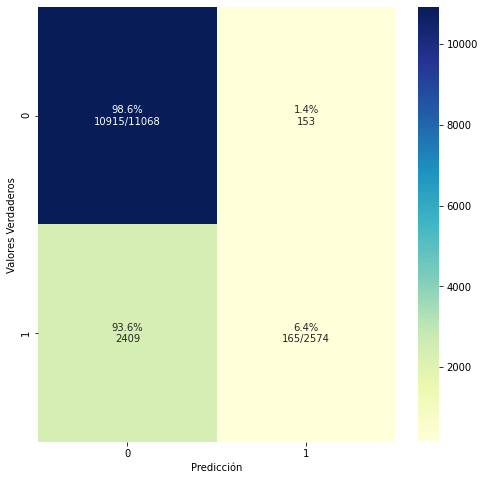

In [74]:
knn = knn_model(15, show=True)

El accuracy es de 81.22% y su precisión de 51.88%, lo que es más alto que el modelo random forest, pero en contraparte tiene solo un 6.4% de recall lo que indica que un porcentaje muy bajo de los que realmente fueron atrasos se clasificaron como tal.

#### SVM

Un modelo SVM es capaz de clasificar de diversas formas una base de datos (lineal, no lineal, como regresión). Esta herramienta funciona idealmente con datasets tamaño pequeño o mediano, por lo que podría ser efectiva en este caso.

El accuracy obtenido en cross validation es de 81.6%

El accuracy del set de test es de 81.13%


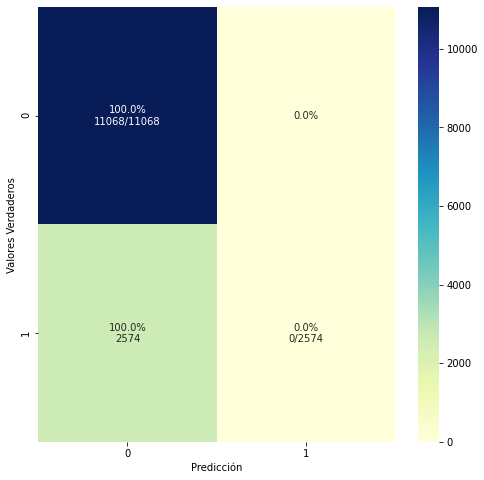

In [75]:
svc_model(show=True)

Por último, el modelo SVM presenta un 81.33% de accuracy pero que proviene en un 100% de la clase 0, es decir, tanto la precisión como el recall de la clase 1 es 0%. Esto se debe a que el algoritmo clasificó todos los datos del set de test como no atrasados. Directamente la recomendación sería no considerar el modelo ya que no se ajusta bien a los datos o explorar otras combinaciones de hiperparámetros que se adapten mejor al dataset.

### Conclusión de los modelos

El modelo que mejor rindió de manera global fue random forest con un 79.12% de accuracy, 25.3% de recall y 41.28% de precisión. Sus resultados no son ideales, por lo que se entregan recomendaciones en la siguientes sección para así aumentar su performance.

En KNN se tuvo una mejor accuracy con 81.22% y una precisión de 51.88%, pero un recall de 6.4% (solo un 6% de los atrasos reales se clasificaron correctamente).

Por otro lado, en SVM se tuvo 81.33% de accuracy pero 0% de precisión y recall, lo que indica una clasificación sin utilidad ya que la totalidad de los datos de testeo dieron como resultado que no hubo atraso.

En todos los casos el accuracy entregado por el set de test y por la cross validation fue similar, lo que indica que no hubo overfitting en el set de entrenamiento y que además se tiene evidencia de que con distintos set de validación los resultados son los mismos, dando más robustes al modelo. Además las desviaciones estándar entre los resultados fueron todas menores a 0.002.

### Recomendaciones para mejorar la performance de los modelos

- Si es que hay más datos disponibles considerar agregarlos al modelo (en este caso se utilizó casi en un 100% datos del 2017). Se debe comprobar que no sean outliers, pero en caso de que no lo sean, podrían aportar información util para que el modelo. Para esto lo ideal es tener información más reciente ya que puede ser mejor predictora de lo que sucede con los atrasos. 


- Disminuir los sesgos en ciertos atributos. Considerar agregar información de todas las operadoras y no concentrar solo 80% en LATAM y Sky Airlines. También agregar más casos en viajes a otros destinos, ya que hay lugares casi sin datos asociados por lo que puede tender a un sobreajuste el modelo. En el caso de que se quiera evaluar exclusivamente a LATAM, considerar entrenar el modelo filtrando todas las filas del dataframe solo con ese operador y ver si aumenta el rendimiento del modelo.


- Agregar más atributos y ver como aportan al modelo. Entre estos se pueden encontrar datos valiosos como días feriados, un booleano que indique si es que el vuelo pertenece a un fin de semana largo, cantidad de pasajeros, cantidad de empleados trabajando en el counter, cantidad de vuelos comprados para el mismo periodo ,cantidad de vuelos con pronóstico de aterrizar o despegar en el mismo periodo (agregar estos últimos dependenderá de qué tan anticipadamente se quiera tener la predicción). También se pueden explorar atributos externos como índice económicos que indiquen gastos en turismo en el último mes, IMACEC, entre otros.


- Iterar con distintos hiperparámetros. En cada modelo existe una serie de hiperparámetros que se pueden modificar. Normalmente vienen ajustados con valores default que se ajustan al comportamiento de los datos y funcionan de buena meanera, pero se pueden cambiar para intentar obtener mejores rendimientos. En este caso se exploró con algunos para llegar a resultados más óptimos.